# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512$\times$512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


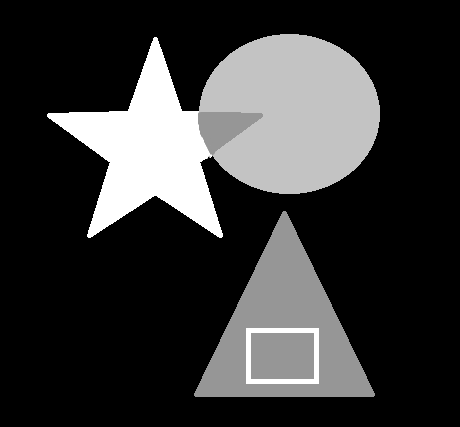


In [ ]:
from skimage.io import imread
from skimage import data
X = data.camera().astype(np.float64) / 255.0

m, n = X.shape
x = X.reshape(m*n)

#dichiarazione variabili immagini geometriche
AA = imread("./img1.png", as_gray=True).astype(np.float64)
aa = AA.reshape(m*n)
BB = imread("./img2.png", as_gray=True).astype(np.float64)
bb = BB.reshape(m*n)
CC = imread("./img3.png", as_gray=True).astype(np.float64)
cc = CC.reshape(m*n)
DD = imread("./img4.png", as_gray=True).astype(np.float64)
dd = DD.reshape(m*n)
EE = imread("./img5.png", as_gray=True).astype(np.float64)
ee = EE.reshape(m*n)
FF = imread("./img6.png", as_gray=True).astype(np.float64)
ff = FF.reshape(m*n)
GG = imread("./img7.png", as_gray=True).astype(np.float64)
gg = GG.reshape(m*n)
HH = imread("./img8.png", as_gray=True).astype(np.float64)
hh = HH.reshape(m*n)
II = imread("./pugile.png", as_gray=True).astype(np.float64)
ii = II.reshape(m*n)
LL = X
ll = LL.reshape(m*n)

#una qualsiasi immagine geometrica (considero img1)
Z = AA
z = aa
plt.imshow(Z, cmap="gray", vmin=0, vmax=1)
plt.title('immagine geometrica qualsiasi Z originale')

#dichiarazione lista immagini geometriche
alfabeto = [AA, BB, CC, DD, EE, FF, GG, HH]

#stampa di tutte le immagini originali
plt.figure(figsize=(30, 20))
i=0
while i<=len(alfabeto):
    if i==0:
        plt.subplot(3, 4, 1).imshow(X, cmap="gray")
        plt.title('Immagine Originale data.camera()')
        i+=1
    else:
        plt.subplot(3, 4, i+1).imshow(alfabeto[i-1], cmap='gray')
        plt.title(f'Immagine Originale img{i}')
        i+=1

plt.subplot(3, 4, i+1).imshow(II, cmap='gray')
plt.title('Immagine Originale pugile')
plt.subplot(3, 4, i+2).imshow(LL, cmap='gray')
plt.title('Immagine Originale giornale')

## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

In [ ]:
from tabulate import tabulate
head = ["Nome Im", "DimKer", "Sigma", "Noise Dev", "PSNR", "MSE"]
tabellaValori = np.array([[5, 0.5, 0.02],
                          [5, 0.5, 0.04],
                          [5, 0.5, 0.08],
                          [5, 0.5, 0.16],
                          [5, 0.5, 0.32],
                          [7, 1, 0.02],
                          [7, 1, 0.04],
                          [7, 1, 0.08],
                          [7, 1, 0.16],
                          [7, 1, 0.32],
                          [9, 1.3, 0.02],
                          [9, 1.3, 0.04],
                          [9, 1.3, 0.08],
                          [9, 1.3, 0.16],
                          [9, 1.3, 0.32]])

for tupla in tabellaValori:
  tabellaFinale = [] #resettata ad ogni inizio di iterazione
  contatoreAscii = 65
  K = psf_fft(gaussian_kernel(int(tupla[0]), tupla[1]), int(tupla[0]), X.shape)
  std_dev = tupla[2]
  noise = np.random.normal(size=X.shape)*std_dev

  X_blur = A(X, K)
  x_blur = X_blur.reshape(m*n)

  B = X_blur + noise
  b = B.reshape(m*n)

  #Maggiore è il valore del PSNR maggiore è la "somiglianza" con l'immagine originale,
  #nel senso che si “avvicina” maggiormente ad essa da un punto di vista percettivo umano.
  # => PSNR(X,X)=inf
  PSNR = metrics.peak_signal_noise_ratio(X, B)

  #blur delle immagini img1-8.png e relativi PSNR
  AA_blur = A(AA, K) + noise
  aa_blur = AA_blur.reshape(m*n)
  PSNR_AA = metrics.peak_signal_noise_ratio(AA,AA_blur)
  MSE_AA = metrics.mean_squared_error(AA, AA_blur)

  BB_blur = A(BB, K) + noise
  bb_blur = BB_blur.reshape(m*n)
  PSNR_BB = metrics.peak_signal_noise_ratio(BB,BB_blur)
  MSE_BB = metrics.mean_squared_error(BB,BB_blur)

  CC_blur = A(CC,K) + noise
  cc_blur = CC_blur.reshape(m*n)
  PSNR_CC = metrics.peak_signal_noise_ratio(CC,CC_blur)
  MSE_CC = metrics.mean_squared_error(CC,CC_blur)

  DD_blur = A(DD,K) + noise
  dd_blur = DD_blur.reshape(m*n)
  PSNR_DD = metrics.peak_signal_noise_ratio(DD,DD_blur)
  MSE_DD = metrics.mean_squared_error(DD,DD_blur)

  EE_blur = A(EE,K) + noise
  ee_blur = EE_blur.reshape(m*n)
  PSNR_EE = metrics.peak_signal_noise_ratio(EE,EE_blur)
  MSE_EE = metrics.mean_squared_error(EE,EE_blur)

  FF_blur = A(FF,K) + noise
  ff_blur = FF_blur.reshape(m*n)
  PSNR_FF = metrics.peak_signal_noise_ratio(FF,FF_blur)
  MSE_FF = metrics.mean_squared_error(FF,FF_blur)

  GG_blur = A(GG,K) + noise
  gg_blur = GG_blur.reshape(m*n)
  PSNR_GG = metrics.peak_signal_noise_ratio(GG,GG_blur)
  MSE_GG = metrics.mean_squared_error(GG,GG_blur)

  HH_blur = A(HH,K) + noise
  hh_blur = HH_blur.reshape(m*n)
  PSNR_HH = metrics.peak_signal_noise_ratio(HH,HH_blur)
  MSE_HH = metrics.mean_squared_error(HH,HH_blur)

  II_blur = A(II, K) + noise
  ii_blur = II_blur.reshape(m*n)
  PSNR_II = metrics.peak_signal_noise_ratio(II,II_blur)
  MSE_II = metrics.mean_squared_error(II,II_blur)

  LL_blur = A(LL, K) + noise
  ll_blur = LL_blur.reshape(m*n)
  PSNR_LL = metrics.peak_signal_noise_ratio(LL,LL_blur)
  MSE_LL = metrics.mean_squared_error(LL,LL_blur)

  #dichiarazione liste immagini geometriche (escludo data.camera() e immagini fotografiche)
  alfabetoblur = [AA_blur, BB_blur, CC_blur, DD_blur, EE_blur, FF_blur, GG_blur, HH_blur]
  xx = [aa_blur, bb_blur, cc_blur, dd_blur, ee_blur, ff_blur, gg_blur, hh_blur]
  psnralfabeto = [PSNR_AA, PSNR_BB, PSNR_CC, PSNR_DD, PSNR_EE, PSNR_FF, PSNR_GG, PSNR_HH, PSNR_II, PSNR_LL]
  msealfabeto = [MSE_AA, MSE_BB, MSE_CC, MSE_DD, MSE_EE, MSE_FF, MSE_GG, MSE_HH, MSE_II, MSE_LL]

  for i in range(10):
    tabellaFinale.append([str(chr(contatoreAscii + i)) + str(chr(contatoreAscii + i)) + "_blur", tupla[0], tupla[1], tupla[2], psnralfabeto[i], msealfabeto[i]])
  print(tabulate(tabellaFinale, headers=head, tablefmt="grid"))
  #calcolo media PSNR e media MSE
  mediapsnr = sum(psnralfabeto) / len(psnralfabeto)
  print('Media PNSR: ', mediapsnr)
  mediamse = sum(msealfabeto) / len(msealfabeto)
  print('Media MSE: ', mediamse)

  #converto in array PSNR e MSE e ricavo std di ognuno
  psnr_array = np.array(psnralfabeto)
  mse_array = np.array(msealfabeto)

  mse_std = np.std(mse_array)
  print('msestd ', mse_std)
  psnr_std = np.std(psnr_array)
  print('psnrstd ', psnr_std)

  #stampa delle immagini originali e corrotte con subplot
  plt.figure(figsize=(60, 10))
  i=0
  plot=1
  while plot<=2*len(alfabeto)+2:
      if plot==1:
          plt.subplot(2, 9, plot).imshow(X, cmap='gray', vmin=0, vmax=1)
          plt.title('Immagine Originale data.camera()')
          i+=1
          plot+=1
      elif plot==10:
          plt.subplot(2, 9, plot).imshow(B, cmap='gray', vmin=0, vmax=1)
          plt.title(f'Immagine Corrotta data.camera() (PSNR: {PSNR:.2f})')
          i=1
          plot+=1
      elif plot<10:
          plt.subplot(2,9,plot).imshow(alfabeto[i-1], cmap='gray')
          plt.title(f'Immagine Originale img{i}')
          i+=1
          plot+=1
      else:
          plt.subplot(2,9,plot).imshow(alfabetoblur[i-1], cmap='gray')
          plt.title(f'Immagine Corrotta img{i} (PSNR: {psnralfabeto[i-1]:.2f}) (MSE: {msealfabeto[i-1]:.5f})')
          plot+=1
          i+=1
  plt.show()

print("\n\n\nISTANZA DEL PROBLEMA\n")
K = psf_fft(gaussian_kernel(9, 1.3), 9, X.shape)
std_dev = 0.02
noise = np.random.normal(size=X.shape)*std_dev

X_blur = A(X, K)
x_blur = X_blur.reshape(m*n)

B = X_blur + noise
b = B.reshape(m*n)

#Maggiore è il valore del PSNR maggiore è la "somiglianza" con l'immagine originale,
#nel senso che si “avvicina” maggiormente ad essa da un punto di vista percettivo umano.
# => PSNR(X,X)=inf
PSNR = metrics.peak_signal_noise_ratio(X, B)

#blur delle immagini img1-8.png e relativi PSNR
AA_blur = A(AA, K) + noise
aa_blur = AA_blur.reshape(m*n)
PSNR_AA = metrics.peak_signal_noise_ratio(AA,AA_blur)
MSE_AA = metrics.mean_squared_error(AA, AA_blur)

BB_blur = A(BB, K) + noise
bb_blur = BB_blur.reshape(m*n)
PSNR_BB = metrics.peak_signal_noise_ratio(BB,BB_blur)
MSE_BB = metrics.mean_squared_error(BB,BB_blur)

CC_blur = A(CC,K) + noise
cc_blur = CC_blur.reshape(m*n)
PSNR_CC = metrics.peak_signal_noise_ratio(CC,CC_blur)
MSE_CC = metrics.mean_squared_error(CC,CC_blur)

DD_blur = A(DD,K) + noise
dd_blur = DD_blur.reshape(m*n)
PSNR_DD = metrics.peak_signal_noise_ratio(DD,DD_blur)
MSE_DD = metrics.mean_squared_error(DD,DD_blur)

EE_blur = A(EE,K) + noise
ee_blur = EE_blur.reshape(m*n)
PSNR_EE = metrics.peak_signal_noise_ratio(EE,EE_blur)
MSE_EE = metrics.mean_squared_error(EE,EE_blur)

FF_blur = A(FF,K) + noise
ff_blur = FF_blur.reshape(m*n)
PSNR_FF = metrics.peak_signal_noise_ratio(FF,FF_blur)
MSE_FF = metrics.mean_squared_error(FF,FF_blur)

GG_blur = A(GG,K) + noise
gg_blur = GG_blur.reshape(m*n)
PSNR_GG = metrics.peak_signal_noise_ratio(GG,GG_blur)
MSE_GG = metrics.mean_squared_error(GG,GG_blur)

HH_blur = A(HH,K) + noise
hh_blur = HH_blur.reshape(m*n)
PSNR_HH = metrics.peak_signal_noise_ratio(HH,HH_blur)
MSE_HH = metrics.mean_squared_error(HH,HH_blur)

II_blur = A(II, K) + noise
ii_blur = II_blur.reshape(m*n)
PSNR_II = metrics.peak_signal_noise_ratio(II,II_blur)
MSE_II = metrics.mean_squared_error(II,II_blur)

LL_blur = A(LL, K) + noise
ll_blur = LL_blur.reshape(m*n)
PSNR_LL = metrics.peak_signal_noise_ratio(LL,LL_blur)
MSE_LL = metrics.mean_squared_error(LL,LL_blur)

#dichiarazione liste immagini geometriche (escludo data.camera() e immagini fotografiche)
alfabetoblur = [AA_blur, BB_blur, CC_blur, DD_blur, EE_blur, FF_blur, GG_blur, HH_blur]
xx = [aa_blur, bb_blur, cc_blur, dd_blur, ee_blur, ff_blur, gg_blur, hh_blur]
psnralfabeto = [PSNR_AA, PSNR_BB, PSNR_CC, PSNR_DD, PSNR_EE, PSNR_FF, PSNR_GG, PSNR_HH]
msealfabeto = [MSE_AA, MSE_BB, MSE_CC, MSE_DD, MSE_EE, MSE_FF, MSE_GG, MSE_HH]

#calcolo media PSNR e media MSE
mediapsnr = sum(psnralfabeto) / len(psnralfabeto)
print('Media PNSR: ', mediapsnr)
mediamse = sum(msealfabeto) / len(msealfabeto)
print('Media MSE: ', mediamse)

#converto in array PSNR e MSE e ricavo std di ognuno
psnr_array = np.array(psnralfabeto)
mse_array = np.array(msealfabeto)

mse_std = np.std(mse_array)
print('msestd ', mse_std)
psnr_std = np.std(psnr_array)
print('psnrstd ', psnr_std)

#stampa delle immagini originali e corrotte con subplot
plt.figure(figsize=(60, 10))
i=0
plot=1
while plot<=2*len(alfabeto)+2:
    if plot==1:
        plt.subplot(2, 9, plot).imshow(X, cmap='gray', vmin=0, vmax=1)
        plt.title('Immagine Originale data.camera()')
        i+=1
        plot+=1
    elif plot==10:
        plt.subplot(2, 9, plot).imshow(B, cmap='gray', vmin=0, vmax=1)
        plt.title(f'Immagine Corrotta data.camera() (PSNR: {PSNR:.2f})')
        i=1
        plot+=1
    elif plot<10:
        plt.subplot(2,9,plot).imshow(alfabeto[i-1], cmap='gray')
        plt.title(f'Immagine Originale img{i}')
        i+=1
        plot+=1
    else:
        plt.subplot(2,9,plot).imshow(alfabetoblur[i-1], cmap='gray')
        plt.title(f'Immagine Corrotta img{i} (PSNR: {psnralfabeto[i-1]:.2f}) (MSE: {msealfabeto[i-1]:.5f})')
        plot+=1
        i+=1
plt.show()


In [ ]:
 # stampa immagini fotografiche
plt.figure(figsize=(20, 10))
plt.subplot(221).imshow(II, cmap='gray')
plt.title('Immagine Originale pugile')
plt.subplot(222).imshow(II_blur, cmap='gray')
plt.title(f'Immagine Corrotta pugile (PSNR: {PSNR_II}) (MSE: {MSE_II:.5f})')

plt.subplot(223).imshow(LL, cmap='gray')
plt.title('Immagine Originale giornale')
plt.subplot(224).imshow(LL_blur, cmap='gray')
plt.title(f'Immagine Corrotta giornale (PSNR: {PSNR_LL}) (MSE: {MSE_LL:.5f})')
plt.show()

## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

In [ ]:
from scipy.optimize import minimize
def f(x, B, labda = 0):
  X = x.reshape(m,n)
  res = 0.5*(np.linalg.norm(A(X, K)-B))**2 + 0.5*labda*(np.linalg.norm(X))**2
  return np.sum(res)
def df(x, B, labda=0):
  X = x.reshape(m,n)
  res = AT(A(X, K)-B, K) + labda*X
  RES = np.reshape(res, m*n)
  return RES



#l'applico all'immagine del cameraman
listaIterazioni = np.arange(51) #0 1 2 3 4 5 6...50 .
listaIterazioni = listaIterazioni[1:] #altrimenti avrebbe incluso anche lo 0

listaValGradCG = []
listaErrRelCG = []
listaPSNRCG = []
listaValFunCG = [] 


for i in listaIterazioni:
  func = lambda x: f(x, B) 
  grad_func = lambda x: df(x, B)
  res = minimize(func, np.zeros(b.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':i})
  RES = res.x.reshape(m,n)
  PSNR = metrics.peak_signal_noise_ratio(X, RES)
  listaValGradCG.append(np.linalg.norm(res.jac.reshape(m,n), "fro"))
  listaErrRelCG.append(np.linalg.norm(RES - X, "fro")/np.linalg.norm(X, "fro"))
  listaPSNRCG.append(PSNR)
  listaValFunCG.append(res.fun) #res.fun = float => scalare


#stampa immagine data.camera() ISTANZA
func = lambda x: f(x, B)
grad_func = lambda x: df(x, B)
res = minimize(func, np.zeros(b.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':6})
RES = res.x.reshape(m,n)
PSNR = metrics.peak_signal_noise_ratio(X, RES)

plt.figure(figsize=(20,15))
plt.title(f'Ripristinata con metodo gradiente coniugato (PSNR: {PSNR})')
plt.imshow(RES, cmap="gray", vmin=0, vmax=1)

In [ ]:
#! stampa delle immagini geometriche
plt.figure(figsize=(60, 15))
i=0
plot=1
while plot<=2*len(alfabeto):
  
    if plot<=8:
        plt.subplot(2,8,plot).imshow(alfabeto[i], cmap='gray')
        plt.title(f'Immagine Originale img{i+1}')
        i+=1
        plot+=1
    else:
        if plot==9:
            i=0
        func = lambda x: f(x, alfabetoblur[i])
        grad_func = lambda x: df(x, alfabetoblur[i])
        xxzeros = xx[i]
        res = minimize(func, np.zeros(xxzeros.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':5})
        RES = res.x.reshape(m,n)
        PSNR = metrics.peak_signal_noise_ratio(alfabeto[i], RES)
        plt.subplot(2, 8, plot).imshow(RES, cmap="gray", vmin=0, vmax=1)
        plt.title(f'img{i+1} ripristinata con metodo gradiente coniugato (PSNR: {PSNR:.2f})')

        plot+=1
        i+=1
plt.show()

In [ ]:
# stampa immagini fotografiche ripristinate
plt.figure(figsize=(10, 20))
 #stampa pugile
func = lambda x: f(x, II_blur)
grad_func = lambda x: df(x, II_blur)
res = minimize(func, np.zeros(ii_blur.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':6})
RES = res.x.reshape(m,n)

PSNR = metrics.peak_signal_noise_ratio(II, RES)
plt.subplot(211).imshow(RES, cmap="gray", vmin=0, vmax=1)
plt.title(f'immagine pugile ripristinata con metodo gradiente coniugato (PSNR: {PSNR_II})')

func = lambda x: f(x, LL_blur)
grad_func = lambda x: df(x, LL_blur)
res = minimize(func, np.zeros(ll_blur.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':6})
RES = res.x.reshape(m,n)

PSNR = metrics.peak_signal_noise_ratio(LL, RES)
plt.subplot(212).imshow(RES, cmap="gray", vmin=0, vmax=1)
plt.title(f'immagine pugile ripristinata con metodo gradiente coniugato (PSNR: {PSNR_LL})')


In [ ]:
listaValGradG = []
listaErrRelG = []
listaPSNRG = []
listaValFunG = []

def next_step(x, grad, B, labda = 0): # backtracking procedure for the choice of the steplength
  alpha=1.1
  c1 = 0.25
  p=-grad
  j=0
  jmax=10
  #condizioni che servono per soddisfare dei criteri di convergenza - condizioni di Wolfe
  while ((f(x + alpha*p, B, labda) > f(x, B, labda)+c1*alpha*grad.T@p) and j<jmax):
    alpha = alpha*0.5
    j+=1
  return alpha

def gradient_minimize(B, labda= 0, maxit=19, abstop = 1.e-6):
  x_last =np.zeros(m*n)
  k = 0
  while (np.linalg.norm(df(x_last, B, labda))>abstop and k < maxit):
    k=k+1
    grad = df(x_last, B, labda)
    step = next_step(x_last, grad, B, labda)

    listaValFunG.append(f(x_last, B))
    x_last=x_last-step*grad

    listaValGradG.append(np.linalg.norm(grad.reshape(m,n), "fro"))
    listaErrRelG.append(np.linalg.norm(x_last.reshape(m,n) - X, "fro")/np.linalg.norm(X, "fro"))
    listaPSNRG.append(metrics.peak_signal_noise_ratio(X, x_last.reshape(m,n)))
  return x_last

z_naive = gradient_minimize(B, labda = 0, maxit = 27)# per studiare comportamento metodi e loro velocità mettere maxit = 50
PSNR = metrics.peak_signal_noise_ratio(X, z_naive.reshape(m,n))
plt.figure(figsize=(30,10))
plt.title(f'Ripristinata con metodo gradiente (PSNR: {PSNR})')
plt.imshow(z_naive.reshape(m,n), cmap="gray")


In [ ]:
#cella usata per studiare metodi !sotto opportuni parametri!. I risultati commentati sono nella relazione
'''
print(f"valore in f di x true = {f(x, B)}")

plt.figure(figsize=(80,80))

plt.subplot(321)
plt.title("BLU=CG   RED=G\nGRADIENTE GENERALE")
plt.grid()
plt.plot(listaIterazioni[4:], listaValGradCG[4:], color="blue", marker="*")
plt.plot(listaIterazioni[4:len(listaValGradG)], listaValGradG[4:], color="red", marker="o")

plt.subplot(322)
plt.title("BLU=CG   RED=G\nGRADIENTE inizio")
plt.grid()
plt.plot(listaIterazioni[4:], listaValGradCG[4:], color="blue")
plt.plot(listaIterazioni[4:len(listaValGradG)], listaValGradG[4:], color="red")

plt.subplot(323)
plt.title("BLU=CG   RED=G\nGRADIENTE fine")
plt.grid()
plt.plot(listaIterazioni[29:], listaValGradCG[29:], color="blue")
plt.plot(listaIterazioni[29:], listaValGradG[29:], color="red")

plt.subplot(324)
plt.title("BLU=CG   RED=G\nVALORE FUNZIONE OBIETTIVO")
plt.grid()
plt.plot(listaIterazioni[5:], listaValFunCG[5:], color="blue")
plt.plot(listaIterazioni[5:], listaValFunG[5:], color="red")


plt.subplot(325)
plt.title("BLU=CG   RED=G\nErr Rel")
plt.grid()
plt.plot(listaIterazioni, listaErrRelCG, color="blue")
plt.plot(listaIterazioni, listaErrRelG, color="red")

plt.subplot(326)
plt.title("BLU=CG   RED=G\nPSNR")
plt.grid()
plt.plot(listaIterazioni, listaPSNRCG, color="blue")
plt.plot(listaIterazioni, listaPSNRG, color="red")
plt.show()
'''

In [ ]:
#! stampa delle immagini geometriche
plt.figure(figsize=(60, 15))
i=0
plot=1
while plot<=2*len(alfabeto):
  
    if plot<=8:
        plt.subplot(2,8, plot).imshow(alfabeto[i], cmap='gray')
        plt.title(f'Immagine Originale img{i+1}')
        i+=1
        plot+=1
    else:
        if plot==9:
            i=0
        a_naive = gradient_minimize(alfabetoblur[i])
        PSNR = metrics.peak_signal_noise_ratio(alfabeto[i], a_naive.reshape(m,n))
        
        i+=1
        plt.subplot(2, 8, plot).imshow(a_naive.reshape(m,n), cmap="gray")
        plt.title(f'img{i} ripristinata con metodo gradiente (PSNR: {PSNR})')
        plot+=1
plt.show()

In [ ]:
# stampa immagini fotografiche
# immagine pugile
z_naive = gradient_minimize(II_blur)
PSNR = metrics.peak_signal_noise_ratio(II, z_naive.reshape(m,n))
plt.figure(figsize=(30,10))
plt.title(f'pugile.png ripristinata con metodo gradiente (PSNR: {PSNR_II})')
plt.imshow(z_naive.reshape(m,n), cmap="gray")

z_naive = gradient_minimize(LL_blur)
PSNR = metrics.peak_signal_noise_ratio(LL, z_naive.reshape(m,n))
plt.figure(figsize=(30,10))
plt.title(f'giornale.png ripristinata con metodo gradiente (PSNR: {PSNR_LL})')
plt.imshow(z_naive.reshape(m,n), cmap="gray")

## 3) Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

In [ ]:
labda = list(np.linspace(1e-7, 1e-1, 100)) 
lista_lambda = []
lista_psnr = []
lista_mse = []

media_psnr=0

massimoPSNR = [-9999, 0] #PSNR e LAMBDA
fotoMaxPSNR = np.zeros((m,n))

minimoPSNR = [9999, 0] #PSNR e LAMBDA
fotoMinPSNR = np.zeros((m,n))

#calcola grafico PSNR
#si analizza come la regolarizzazione possa migliorare psnr dell'immagine blurrata 
for i in range(100): 
  func = lambda x: f(x, B, labda[i])
  grad_func = lambda x: df(x, B, labda[i])
  res = minimize(func, np.zeros(b.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':6})
  RES = res.x.reshape(m,n)

  PSNR = metrics.peak_signal_noise_ratio(X, RES)
  MSE = metrics.mean_squared_error(X, RES)

  massimoPSNR[0] = max(massimoPSNR[0], PSNR)
  if massimoPSNR[0] == PSNR:
    fotoMaxPSNR = RES
    massimoPSNR[1] = labda[i]

  minimoPSNR[0] = min(minimoPSNR[0], PSNR)
  if minimoPSNR[0] == PSNR:
    fotoMinPSNR = RES
    minimoPSNR[1] = labda[i]

  lista_psnr.append(PSNR)
  lista_mse.append(MSE)
  lista_lambda.append(labda[i])
  media_psnr += PSNR
  print(f'lambda: {labda[i]} PSNR: {PSNR:.2f} MSE: {MSE:.5f}')
print(f'media psnr = {media_psnr/100}')

#https://www.geeksforgeeks.org/how-to-add-a-y-axis-label-to-the-secondary-y-axis-in-matplotlib/
# stampa grafico PSNR
fig, ax = plt.subplots(figsize = (10, 5))

ax2 = ax.twinx()
ax.plot(lista_lambda, lista_psnr, label='PSNR', color = "orange")
ax.plot(lista_lambda, [media_psnr/100 for i in range(100)], label='media PSNR', color = "orange")
ax2.plot(lista_lambda, lista_mse, label='MSE', color = "blue")

plt.title('Grafico data.camera(): ricostruzione con il metodo di regolarizzazione')
plt.legend(['PSNR', 'MSE'], loc='upper right')
plt.grid()

# giving labels to the axises
ax.set_xlabel('lambda')
ax.set_ylabel('PSNR e media')

# secondary y-axis label
ax2.set_ylabel("MSE")
 
# defining display layout
plt.tight_layout()
 
# show plot
plt.show()


plt.figure(figsize=(25, 75))
plt.subplot(131)
plt.title(f"Immagine corrotta\nPSNR = {metrics.peak_signal_noise_ratio(X, B)}")
plt.imshow(B, cmap="gray")
plt.subplot(132)
plt.title(f"Miglior immagine ottenuta con regolarizzazione\nPSNR = {massimoPSNR[0]} lambda = {massimoPSNR[1]}")
plt.imshow(fotoMaxPSNR, cmap="gray")
plt.subplot(133)
plt.title(f"Peggior immagine ottenuta con regolarizzazione\nPSNR = {minimoPSNR[0]} lambda = {minimoPSNR[1]}")
plt.imshow(fotoMinPSNR, cmap="gray")
plt.show()

In [ ]:
#! stampa per immagini geometriche
contatoreAscii = 65
labda = list(np.linspace(1e-7, 1e-1, 100))
alp=0
while alp<len(alfabetoblur):
  # lista per grafico resettati per ogni immagine
  lista_lambda = []
  lista_psnr = []
  lista_mse = []

  media_psnr=0

  massimoPSNR = [-9999, 0] #PSNR e LAMBDA
  fotoMaxPSNR = np.zeros((m,n))

  minimoPSNR = [9999, 0] #PSNR e LAMBDA
  fotoMinPSNR = np.zeros((m,n))
  
  for i in range(100):             
    func = lambda x: f(x, alfabetoblur[alp], labda[i])
    grad_func = lambda x: df(x, alfabetoblur[alp], labda[i])
    res = minimize(func, np.zeros(xx[alp].shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':5})
    RES = res.x.reshape(m,n)
    
    PSNR = metrics.peak_signal_noise_ratio(alfabeto[alp], RES)
    MSE = metrics.mean_squared_error(alfabeto[alp], RES)

    massimoPSNR[0] = max(massimoPSNR[0], PSNR)
    if massimoPSNR[0] == PSNR:
      fotoMaxPSNR = RES
      massimoPSNR[1] = labda[i]

    minimoPSNR[0] = min(minimoPSNR[0], PSNR)
    if minimoPSNR[0] == PSNR:
      fotoMinPSNR = RES
      minimoPSNR[1] = labda[i]

    media_psnr += PSNR
    
    lista_psnr.append(PSNR)
    lista_mse.append(MSE)
    lista_lambda.append(labda[i])
    print(f'img{alp+1} -> lambda: {labda[i]} PSNR: {PSNR} MSE: {MSE}')
  
  print(f'media psnr = {media_psnr/100}')
  alp+=1
  # stampa grafico
  fig, ax = plt.subplots(figsize = (10, 5))

  ax2 = ax.twinx()
  ax.plot(lista_lambda, lista_psnr, label='PSNR', color = "orange")
  ax.plot(lista_lambda, [media_psnr/100 for i in range(100)], label='media PSNR', color = "orange")
  ax2.plot(lista_lambda, lista_mse, label='MSE', color = "blue")

  plt.title(f'Grafico: ricostruzione con il metodo di regolarizzazione img{alp}')
  plt.legend(['PSNR', 'MSE'], loc='upper right')
  plt.grid()

  # giving labels to the axises
  ax.set_xlabel('lambda')
  ax.set_ylabel('PSNR e media')

  # secondary y-axis label
  ax2.set_ylabel("MSE")
 
  # defining display layout
  plt.tight_layout()
 
  # show plot
  plt.show()

  exec("immagineOriginale = " + str(chr(contatoreAscii + alp - 1)) + str(chr(contatoreAscii + alp - 1)))
  exec("immagineCorrotta = " + str(chr(contatoreAscii + alp - 1)) + str(chr(contatoreAscii + alp - 1)) + "_blur")
  plt.figure(figsize=(25, 75))
  plt.subplot(131)
  plt.title(f"Immagine corrotta\nPSNR = {metrics.peak_signal_noise_ratio(immagineOriginale, immagineCorrotta)}")
  plt.imshow(immagineCorrotta, cmap="gray")
  plt.subplot(132)
  plt.title(f"Miglior immagine ottenuta con regolarizzazione\nPSNR = {massimoPSNR[0]} lambda = {massimoPSNR[1]}")
  plt.imshow(fotoMaxPSNR, cmap="gray")
  plt.subplot(133)
  plt.title(f"Peggior immagine ottenuta con regolarizzazione\nPSNR = {minimoPSNR[0]} lambda = {minimoPSNR[1]}")
  plt.imshow(fotoMinPSNR, cmap="gray")
  plt.show()

In [ ]:
# stampa grafico immagini fotografiche
labda = list(np.linspace(1e-7, 1e-1, 100))
# lista per grafico 
lista_lambda = []
lista_psnr = []
lista_mse = []

media_psnr=0

massimoPSNR = [-9999, 0] #PSNR e LAMBDA
fotoMaxPSNR = np.zeros((m,n))

minimoPSNR = [9999, 0] #PSNR e LAMBDA
fotoMinPSNR = np.zeros((m,n))
#pugile.png
for i in range(100): 
  func = lambda x: f(x, II_blur, labda[i])
  grad_func = lambda x: df(x, II_blur, labda[i])
  res = minimize(func, np.zeros(ii_blur.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':5})
  RES = res.x.reshape(m,n)

  PSNR = metrics.peak_signal_noise_ratio(II, RES)
  MSE = metrics.mean_squared_error(II, RES)

  massimoPSNR[0] = max(massimoPSNR[0], PSNR)
  if massimoPSNR[0] == PSNR:
    fotoMaxPSNR = RES
    massimoPSNR[1] = labda[i]

  minimoPSNR[0] = min(minimoPSNR[0], PSNR)
  if minimoPSNR[0] == PSNR:
    fotoMinPSNR = RES
    minimoPSNR[1] = labda[i]
  
  media_psnr += PSNR
  lista_psnr.append(PSNR)
  lista_mse.append(MSE)
  lista_lambda.append(labda[i])
  print(f'lambda: {labda[i]} PSNR: {PSNR}  MSE: {MSE}')

# stampa grafico

fig, ax = plt.subplots(figsize = (10, 5))

ax2 = ax.twinx()
ax.plot(lista_lambda, lista_psnr, label='PSNR', color = "orange")
ax.plot(lista_lambda, [media_psnr/100 for i in range(100)], label='media PSNR', color = "orange")
ax2.plot(lista_lambda, lista_mse, label='MSE', color = "blue")

plt.title('Grafico PSNR pugile: ricostruzione con il metodo di regolarizzazione')
plt.legend(['PSNR', 'MSE'], loc='upper right')
plt.grid()

# giving labels to the axises
ax.set_xlabel('lambda')
ax.set_ylabel('PSNR e media')

# secondary y-axis label
ax2.set_ylabel("MSE")
 
# defining display layout
plt.tight_layout()
 
# show plot
plt.show()





plt.figure(figsize=(25, 75))
plt.subplot(131)
plt.title(f"Immagine corrotta\nPSNR = {metrics.peak_signal_noise_ratio(II, II_blur)}")
plt.imshow(II_blur, cmap="gray")
plt.subplot(132)
plt.title(f"Miglior immagine ottenuta con regolarizzazione\nPSNR = {massimoPSNR[0]} lambda = {massimoPSNR[1]}")
plt.imshow(fotoMaxPSNR, cmap="gray")
plt.subplot(133)
plt.title(f"Peggior immagine ottenuta con regolarizzazione\nPSNR = {minimoPSNR[0]} lambda = {minimoPSNR[1]}")
plt.imshow(fotoMinPSNR, cmap="gray")
plt.show()





lista_lambda = []
lista_psnr = []
lista_mse = []

media_psnr=0

massimoPSNR = [-9999, 0] #PSNR e LAMBDA
fotoMaxPSNR = np.zeros((m,n))

minimoPSNR = [9999, 0] #PSNR e LAMBDA
fotoMinPSNR = np.zeros((m,n))

#giornale.png
for i in range(100): 
  func = lambda x: f(x, LL_blur, labda[i])
  grad_func = lambda x: df(x, LL_blur, labda[i])
  res = minimize(func, np.zeros(ll_blur.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':5})
  RES = res.x.reshape(m,n)

  PSNR = metrics.peak_signal_noise_ratio(LL, RES)
  MSE = metrics.mean_squared_error(LL, RES)

  massimoPSNR[0] = max(massimoPSNR[0], PSNR)
  if massimoPSNR[0] == PSNR:
    fotoMaxPSNR = RES
    massimoPSNR[1] = labda[i]

  minimoPSNR[0] = min(minimoPSNR[0], PSNR)
  if minimoPSNR[0] == PSNR:
    fotoMinPSNR = RES
    minimoPSNR[1] = labda[i]
  
  media_psnr += PSNR
  lista_psnr.append(PSNR)
  lista_mse.append(MSE)
  lista_lambda.append(labda[i])
  print(f'lambda: {labda[i]} PSNR: {PSNR} MSE: {MSE}')

# stampa grafico

fig, ax = plt.subplots(figsize = (10, 5))

ax2 = ax.twinx()
ax.plot(lista_lambda, lista_psnr, label='PSNR', color = "orange")
ax.plot(lista_lambda, [media_psnr/100 for i in range(100)], label='media PSNR', color = "orange")
ax2.plot(lista_lambda, lista_mse, label='MSE', color = "blue")

plt.title('Grafico Giornale: ricostruzione con il metodo di regolarizzazione')
plt.legend(['PSNR', 'MSE'], loc='upper right')
plt.grid()

# giving labels to the axises
ax.set_xlabel('lambda')
ax.set_ylabel('PSNR e media')

# secondary y-axis label
ax2.set_ylabel("MSE")
 
# defining display layout
plt.tight_layout()
 
# show plot
plt.show()


plt.figure(figsize=(25, 75))
plt.subplot(131)
plt.title(f"Immagine corrotta\nPSNR = {metrics.peak_signal_noise_ratio(LL, LL_blur)}")
plt.imshow(LL_blur, cmap="gray")
plt.subplot(132)
plt.title(f"Miglior immagine ottenuta con regolarizzazione\nPSNR = {massimoPSNR[0]} lambda = {massimoPSNR[1]}")
plt.imshow(fotoMaxPSNR, cmap="gray")
plt.subplot(133)
plt.title(f"Peggior immagine ottenuta con regolarizzazione\nPSNR = {minimoPSNR[0]} lambda = {minimoPSNR[1]}")
plt.imshow(fotoMinPSNR, cmap="gray")
plt.show()



In [ ]:

labda = list(np.linspace(1e-5, 0.02, 100))
media_psnr=0
lista_psnr = []
lista_mse = []

massimoPSNR = [-9999, 0] #PSNR e LAMBDA
fotoMaxPSNR = np.zeros((m,n))


for i in range(100):
  z_tikhonov = gradient_minimize(B, labda[i], maxit = 27)
  PSNR = metrics.peak_signal_noise_ratio(X, z_tikhonov.reshape(m,n))
  MSE = metrics.mean_squared_error(X, z_tikhonov.reshape(m,n))

  massimoPSNR[0] = max(massimoPSNR[0], PSNR)
  if massimoPSNR[0] == PSNR:
    fotoMaxPSNR = z_tikhonov.reshape(m,n)
    massimoPSNR[1] = labda[i]

  
  media_psnr += PSNR
  lista_psnr.append(PSNR)
  lista_mse.append(MSE)
  print(f'lambda: {labda[i]} PSNR: {PSNR}')


fig, ax = plt.subplots(figsize = (10, 5))

ax2 = ax.twinx()
ax.plot(labda, lista_psnr, label='PSNR', color = "orange")
ax.plot(labda, [media_psnr/100 for i in range(100)], label='media PSNR', color = "orange")
ax2.plot(labda, lista_mse, label='MSE', color = "blue")

plt.title('Grafico Cameramen: ricostruzione con il metodo di regolarizzazione')
plt.legend(['PSNR', 'MSE'], loc='upper right')
plt.grid()

# giving labels to the axises
ax.set_xlabel('lambda')
ax.set_ylabel('PSNR e media')

# secondary y-axis label
ax2.set_ylabel("MSE")
 
# defining display layout
plt.tight_layout()
 
# show plot
plt.show()


plt.figure(figsize=(25, 75))
plt.subplot(121)
plt.title(f"Immagine corrotta\nPSNR = {metrics.peak_signal_noise_ratio(X, B)}")
plt.imshow(B, cmap="gray")
plt.subplot(122)
plt.title(f"Miglior immagine ottenuta con gradiente regolarizzato \nPSNR = {massimoPSNR[0]} lambda = {massimoPSNR[1]}")
plt.imshow(fotoMaxPSNR, cmap="gray")
plt.show()


In [ ]:

#! stampa immagini geometriche ripristinate (anche quelle fotografiche)


alfabetoblur = [AA_blur, BB_blur, CC_blur, DD_blur, EE_blur, FF_blur, GG_blur, HH_blur, II_blur, LL_blur]
alfabeto = [AA, BB, CC, DD, EE, FF, GG, HH, II, LL]
alp=0
labda = list(np.linspace(1e-5, 0.035, 100))
while alp<len(alfabetoblur):
  media_psnr=0
  lista_psnr = []
  lista_mse = []

  massimoPSNR = [-9999, 0] #PSNR e LAMBDA
  fotoMaxPSNR = np.zeros((m,n))

  for i in range(100):
    z_tikhonov = gradient_minimize(alfabetoblur[alp], labda[i])
    PSNR = metrics.peak_signal_noise_ratio(alfabeto[alp], z_tikhonov.reshape(m,n))
    MSE = metrics.mean_squared_error(alfabeto[alp], z_tikhonov.reshape(m,n))

    massimoPSNR[0] = max(massimoPSNR[0], PSNR)
    if massimoPSNR[0] == PSNR:
      fotoMaxPSNR = z_tikhonov.reshape(m,n)
      massimoPSNR[1] = labda[i]
  
    media_psnr += PSNR
    lista_psnr.append(PSNR)
    lista_mse.append(MSE)
    print(f'img{alp} -> lambda: {labda[i]} PSNR: {PSNR}')
  
  fig, ax = plt.subplots(figsize = (10, 5))

  ax2 = ax.twinx()
  ax.plot(labda, lista_psnr, label='PSNR', color = "orange")
  ax.plot(labda, [media_psnr/100 for i in range(100)], label='media PSNR', color = "orange")
  ax2.plot(labda, lista_mse, label='MSE', color = "blue")

  plt.title(f'Grafico img{alp}: ricostruzione con il metodo del gradiente regolarizzato')
  plt.legend(['PSNR', 'MSE'], loc='upper right')
  plt.grid()

  # giving labels to the axises
  ax.set_xlabel('lambda')
  ax.set_ylabel('PSNR e media')

  # secondary y-axis label
  ax2.set_ylabel("MSE")
 
  # defining display layout
  plt.tight_layout()
 
  # show plot
  plt.show()


  plt.figure(figsize=(25, 75))
  plt.subplot(121)
  plt.title(f"Immagine corrotta\nPSNR = {metrics.peak_signal_noise_ratio(alfabeto[alp], alfabetoblur[alp])}")
  plt.imshow(alfabetoblur[alp], cmap="gray")
  plt.subplot(122)
  plt.title(f"Miglior immagine ottenuta con regolarizzazione\nPSNR = {massimoPSNR[0]} lambda = {massimoPSNR[1]}")
  plt.imshow(fotoMaxPSNR, cmap="gray")
  plt.show()

  alp+=1

## 4) Variazione Totale (Facoltativo) 

Un altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [ ]:
eps = 1e-2

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div

In [ ]:
def f_tv(x, B, labda):
  X = x.reshape(m,n)
  res = 0.5*(np.linalg.norm(A(X, K)-B))**2 + labda*totvar(X)
  return np.sum(res)
def df_tv(x, B, labda):
  X = x.reshape(m,n)
  res = AT(A(X, K)-B, K) + labda*grad_totvar(X)
  RES = np.reshape(res, m*n)
  return RES
def next_step_tv(x,grad, B, labda): # backtracking procedure for the choice of the steplength
  alpha=1.1
  c1 = 0.25
  p=-grad
  j=0
  jmax=10
  #condizioni che servono per soddisfare dei criteri di convergenza - condizioni di Wolfe
  while ((f_tv(x + alpha*p, B, labda) > f_tv(x, B, labda)+c1*alpha*grad.T@p) and j<jmax):
    alpha= alpha*0.5
    j+=1
  return alpha
def gradient_minimize_tv(B, labda, maxit=27, abstop = 1.e-6):
  x_last = x0=np.zeros(m*n)
  k = 0
  while (np.linalg.norm(df_tv(x_last, B, labda))>abstop and k < maxit):
    k=k+1
    grad = df_tv(x_last, B, labda)
    step = next_step_tv(x_last, grad, B, labda)
    x_last=x_last-step*grad
  return x_last

In [ ]:

labda = list(np.linspace(0.00001, 0.02, 150))
immaginiCorrotteLista = [II_blur,  LL_blur] #le immagini corrotte sono quelle del tipo X_blur + noise
immaginiPuliteLista = [II, LL] #sono le immagini pulite

#per ogni immagine
listaPSNR_II = []
listaMSE_II = []
listaERRREL_II = []
massimoPSNR_II = [-9999, 0] #PSNR e LAMBDA
fotoMaxPSNR_II = np.zeros((m,n))
mediaPSNR_II = 0

listaPSNR_LL = []
listaMSE_LL = []
listaERRREL_LL = []
massimoPSNR_LL = [-9999, 0] #PSNR e LAMBDA
fotoMaxPSNR_LL = np.zeros((m,n))
mediaPSNR_LL = 0

for j in range(len(immaginiCorrotteLista)):
  for i in range(150):
    ricostruzione_tv = gradient_minimize_tv(immaginiCorrotteLista[j], labda[i])
    RICOSTRUZIONE_tv = ricostruzione_tv.reshape(m,n) #per convenzione abbiamo usato che le variabili in minuscolo sono vettori di dimensione m*n mentre le variabili in MAIUSCOLO sono MATRICI di dimensione (m,n)
    PSNR = metrics.peak_signal_noise_ratio(immaginiPuliteLista[j], RICOSTRUZIONE_tv) #primo argomento immagine pulita, secondo argomento l'immagine ricostruita col metodo che stiamo utilizzando attualmente
    MSE = metrics.mean_squared_error(immaginiPuliteLista[j], RICOSTRUZIONE_tv)
    erroreRelativo = np.linalg.norm(RICOSTRUZIONE_tv - immaginiPuliteLista[j], 'fro')/np.linalg.norm(immaginiPuliteLista[j], 'fro') #errore relativo in norma di frobenius.

    #per ogni immagine
    if (immaginiCorrotteLista[j] is II_blur):
      listaPSNR_II.append(PSNR)
      listaMSE_II.append(MSE)
      listaERRREL_II.append(erroreRelativo)
      massimoPSNR_II[0] = max(massimoPSNR_II[0], PSNR)
      if massimoPSNR_II[0] == PSNR:
        massimoPSNR_II[1] = labda[i]
        fotoMaxPSNR_II = RICOSTRUZIONE_tv
      mediaPSNR_II+= PSNR
      print(f'sto analizzando immagine II_blur. lambda: {labda[i]} PSNR: {PSNR:.2f} MSE: {MSE} Errore relativo: {erroreRelativo}')
    
    elif immaginiCorrotteLista[j] is LL_blur:
      listaPSNR_LL.append(PSNR)
      listaMSE_LL.append(MSE)
      listaERRREL_LL.append(erroreRelativo)
      massimoPSNR_LL[0] = max(massimoPSNR_LL[0], PSNR)
      if massimoPSNR_LL[0] == PSNR:
        massimoPSNR_LL[1] = labda[i]
        fotoMaxPSNR_LL = RICOSTRUZIONE_tv
      mediaPSNR_LL+= PSNR
      print(f'sto analizzando immagine LL_blur. lambda: {labda[i]} PSNR: {PSNR:.2f} MSE: {MSE} Errore relativo: {erroreRelativo}')


#dopo che ho ottenuto le mie liste sono pronto a plottare (sempre per ogni immagine)
for j in range(len(immaginiCorrotteLista)):
  #per ogni immagine
  if (immaginiCorrotteLista[j] is II_blur):

    plt.figure(figsize=(30,10))
    plt.plot(labda, listaPSNR_II, label='PSNR', color="blue")
    plt.plot(labda, [mediaPSNR_II/len(labda) for i in range(len(labda))], label='media PSNR', color="black")
    plt.legend("PSNR", "media PSNR") #accetta al massimo due
    plt.grid()
    plt.show()


    fig, ax = plt.subplots(figsize = (30, 10))

    ax2 = ax.twinx()
    ax.plot(labda, listaERRREL_II, label='ERRORE RELATIVO', color = "green", marker="*")
    ax2.plot(labda, listaMSE_II, label='MSE', color = "blue", marker="o")

    plt.title(f'STO ANALIZZANDO RICOSTRUZIONE RIGUARDO II (II_blur ERA LA SUA CORROTTA\n verde = ERR REL; blu = MSE')
    plt.legend(['ERR REL', 'MSE'], loc='upper right')
    plt.grid()

    # giving labels to the axises
    ax.set_xlabel('lambda')
    ax.set_ylabel('ERR REL')

    # secondary y-axis label
    ax2.set_ylabel("MSE")
 
    # defining display layout
    plt.tight_layout()
 
    # show plot
    plt.show()
  
  elif immaginiCorrotteLista[j] is LL_blur:

    plt.figure(figsize=(30,10))
    plt.plot(labda, listaPSNR_LL, label='PSNR', color="blue")
    plt.plot(labda, [mediaPSNR_LL/len(labda) for i in range(len(labda))], label='media PSNR', color="black")
    plt.legend("PSNR", "media PSNR")
    plt.grid()
    plt.show()

    fig, ax = plt.subplots(figsize = (30, 10))

    ax2 = ax.twinx()
    ax.plot(labda, listaERRREL_LL, label='ERRORE RELATIVO', color = "green", marker="*")
    ax2.plot(labda, listaMSE_LL, label='MSE', color = "blue", marker="o")

    plt.title(f'STO ANALIZZANDO RICOSTRUZIONE RIGUARDO LL (LL_blur ERA LA SUA CORROTTA\n verde = ERR REL; blu = MSE')
    plt.legend(['ERR REL', 'MSE'], loc='upper right')
    plt.grid()

    # giving labels to the axises
    ax.set_xlabel('lambda')
    ax.set_ylabel('ERR REL')

    # secondary y-axis label
    ax2.set_ylabel("MSE")
 
    # defining display layout
    plt.tight_layout()
 
    # show plot
    plt.show()


plt.suptitle("ORIGINALE, CORROTTA, RICOSTRUITA PUGILE")
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(II, cmap="gray")
plt.subplot(1,3,2)
plt.imshow(II_blur, cmap="gray")
plt.subplot(1,3,3)
plt.imshow(fotoMaxPSNR_II, cmap="gray")
plt.show()

plt.suptitle("ORIGINALE, CORROTTA, RICOSTRUITA GIORNALE")
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(LL, cmap="gray")
plt.subplot(1,3,2)
plt.imshow(LL_blur, cmap="gray")
plt.subplot(1,3,3)
plt.imshow(fotoMaxPSNR_LL, cmap="gray")
plt.show()


In [ ]:
#! stampa immagini geometriche ripristinate


alfabetoblur = [BB_blur, DD_blur, FF_blur] #analizzo 3 immagini geometriche
alfabeto = [BB, DD, FF]

labda = list(np.linspace(0.02, 0.05, 150))

for aaa in range(len(alfabetoblur)):

  media_psnr=0
  lista_psnr = []
  lista_mse = []

  massimoPSNR = [-9999, 0] #PSNR e LAMBDA
  fotoMaxPSNR = np.zeros((m,n))

  for i in range(150):
    z_tv = gradient_minimize_tv(alfabetoblur[aaa], labda[i])
    PSNR = metrics.peak_signal_noise_ratio(alfabeto[aaa], z_tv.reshape(m,n))
    MSE = metrics.mean_squared_error(alfabeto[aaa], z_tv.reshape(m,n))

    massimoPSNR[0] = max(massimoPSNR[0], PSNR)
    if massimoPSNR[0] == PSNR:
      fotoMaxPSNR = z_tv.reshape(m,n)
      massimoPSNR[1] = labda[i]
  
    media_psnr += PSNR
    lista_psnr.append(PSNR)
    lista_mse.append(MSE)
  
  fig, ax = plt.subplots(figsize = (10, 5))

  ax2 = ax.twinx()
  ax.plot(labda, lista_psnr, label='PSNR', color = "orange")
  ax.plot(labda, [media_psnr/150 for i in range(150)], label='media PSNR', color = "orange")
  ax2.plot(labda, lista_mse, label='MSE', color = "blue")

  plt.title(f'Grafico img{aaa}: ricostruzione con regolarizzazione TOT VAR')
  plt.legend(['PSNR', 'MSE'], loc='upper right')
  plt.grid()

  # giving labels to the axises
  ax.set_xlabel('lambda')
  ax.set_ylabel('PSNR e media')

  # secondary y-axis label
  ax2.set_ylabel("MSE")
 
  # defining display layout
  plt.tight_layout()
 
  # show plot
  plt.show()

  plt.figure(figsize=(25, 75))
  plt.subplot(121)
  plt.title(f"Immagine corrotta\nPSNR = {metrics.peak_signal_noise_ratio(alfabeto[aaa], alfabetoblur[aaa])}")
  plt.imshow(alfabetoblur[aaa], cmap="gray")
  plt.subplot(122)
  plt.title(f"Miglior immagine ottenuta con regolarizzazione\nPSNR = {massimoPSNR[0]} lambda = {massimoPSNR[1]}")
  plt.imshow(fotoMaxPSNR, cmap="gray")
  plt.show()

# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

